# 2Hop Multiple Choice Answers Questions

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import string
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Load the CSV file
df = pd.read_csv('data/2hop_MCQ.csv')  # Replace with your actual CSV file path

# Verify the number of rows
print(f"Loaded {len(df)} questions")

Loaded 500 questions


In [3]:
# Compare errors between with-context and without-context approaches
print("\nError Analysis:")
print("-" * 100)
print(f"{'Question':50} | {'Truth':5} | {'With Ctx':8} | {'Without Ctx':10} | {'Notes'}")
print("-" * 100)

# Count different error types
context_helped_count = 0
context_misled_count = 0
both_incorrect_count = 0
both_correct_count = 0

for i, row in df.iterrows():
    # Get standardized answers for comparison
    ground_truth = row['standardized_answer']
    with_context = row['with_context_parsed']
    without_context = row['without_context_parsed']
    
    # Check if either prediction is incorrect (using standardized answers)
    with_context_correct = (with_context == ground_truth) if (with_context is not None and ground_truth is not None) else False
    without_context_correct = (without_context == ground_truth) if (without_context is not None and ground_truth is not None) else False
    
    # Track counts for summary
    if with_context_correct and without_context_correct:
        both_correct_count += 1
    elif with_context_correct and not without_context_correct:
        context_helped_count += 1
    elif not with_context_correct and without_context_correct:
        context_misled_count += 1
    elif not with_context_correct and not without_context_correct:
        both_incorrect_count += 1
    
    # Only show questions where at least one approach was incorrect
    if not (with_context_correct and without_context_correct) and ground_truth is not None:
        # Truncate question for display
        question = row['question'][:47] + "..." if len(row['question']) > 47 else row['question'].ljust(47)
        
        # Format for display
        truth_display = str(ground_truth).ljust(5) if ground_truth else "None".ljust(5)
        with_ctx_display = str(with_context).ljust(8) if with_context else "None".ljust(8)
        without_ctx_display = str(without_context).ljust(10) if without_context else "None".ljust(10)
        
        # Determine notes
        if with_context_correct and not without_context_correct:
            notes = "Context helped"
        elif not with_context_correct and without_context_correct:
            notes = "Context misled"
        else:
            notes = "Both incorrect"
            
        print(f"{question} | {truth_display} | {with_ctx_display} | {without_ctx_display} | {notes}")

# Print summary statistics
total_questions = len(df)
answerable_questions = sum(1 for ans in df['standardized_answer'] if ans is not None)

print("\nSummary Statistics:")
print(f"Total questions: {total_questions}")
print(f"Answerable questions (with valid ground truth): {answerable_questions}")
print(f"Both approaches correct: {both_correct_count} ({both_correct_count/answerable_questions*100:.1f}% of answerable)")
print(f"Context helped: {context_helped_count} ({context_helped_count/answerable_questions*100:.1f}% of answerable)")
print(f"Context misled: {context_misled_count} ({context_misled_count/answerable_questions*100:.1f}% of answerable)")
print(f"Both approaches incorrect: {both_incorrect_count} ({both_incorrect_count/answerable_questions*100:.1f}% of answerable)")

# Net impact of context
net_impact = context_helped_count - context_misled_count
print(f"\nNet impact of context: {'+' if net_impact > 0 else ''}{net_impact} questions " +
      f"({net_impact/answerable_questions*100:.1f}% of answerable)")


Error Analysis:
----------------------------------------------------------------------------------------------------
Question                                           | Truth | With Ctx | Without Ctx | Notes
----------------------------------------------------------------------------------------------------
Can dry AMD progress to geographic atrophy due ... | B     | B        | A          | Context helped
Does hypertension worsen AMD by elevating choro... | B     | A        | A          | Both incorrect
Does UV exposure accelerate AMD by triggering i... | B     | A        | B          | Context misled
Can AREDS supplements slow dry AMD by reversing... | B     | A        | C          | Both incorrect
Does diabetes heighten AMD risk by causing dire... | B     | A        | A          | Both incorrect
Does a diet rich in leafy greens reduce AMD ris... | B     | C        | A          | Both incorrect
Can wet AMD cause legal blindness by impairing ... | B     | A        | A          | Both


Context Impact Summary:
Neutral: 291 questions (58.2%)
No Help: 137 questions (27.4%)
Positive: 56 questions (11.2%)
Negative: 16 questions (3.2%)

Net Positive Impact: 40 questions (8.0%)


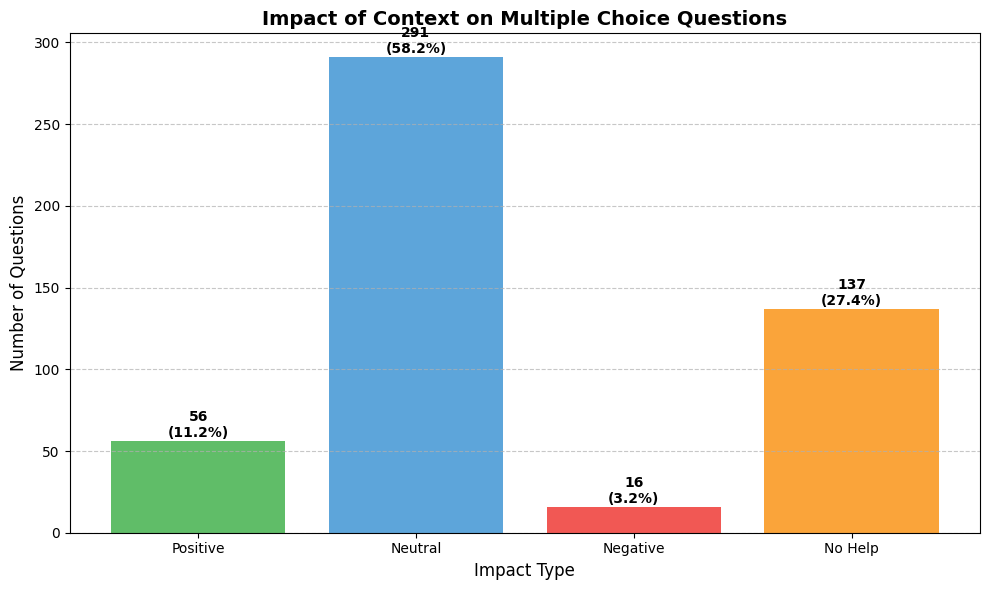


Feature Analysis for Context Impact:

Feature: is_cause_effect
  Questions with this feature: 76
  Positive impact rate: 9.2%
  Negative impact rate: 3.9%
  Net positive rate: 5.3%

Feature: mentions_specific_condition
  Questions with this feature: 225
  Positive impact rate: 9.3%
  Negative impact rate: 2.7%
  Net positive rate: 6.7%

Feature: mentions_therapy
  Questions with this feature: 56
  Positive impact rate: 7.1%
  Negative impact rate: 0.0%
  Net positive rate: 7.1%


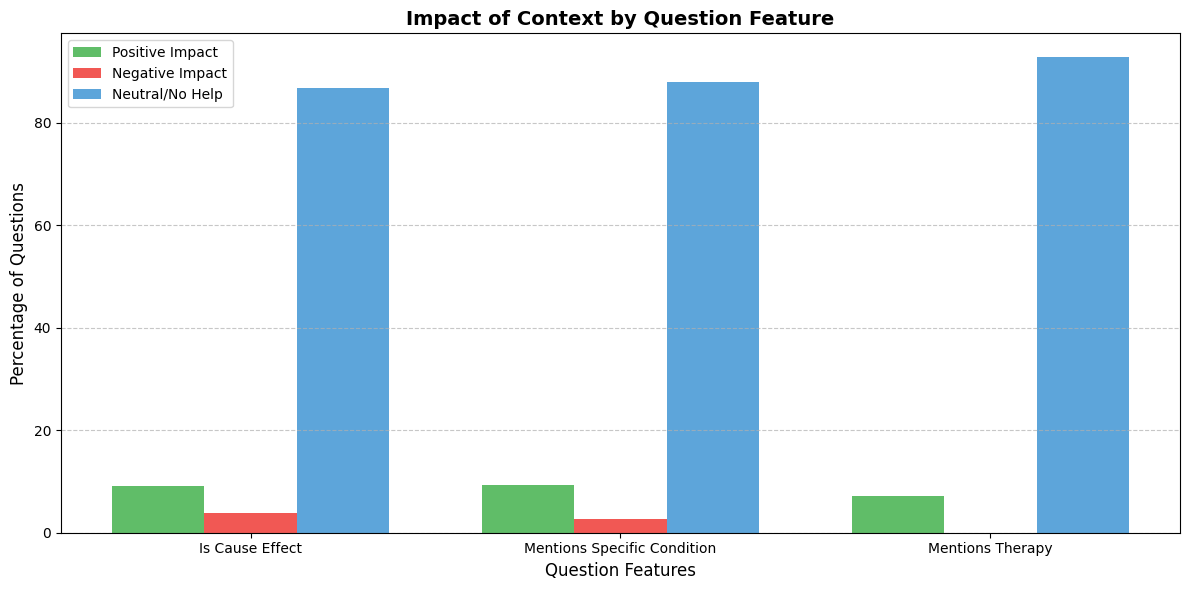

In [4]:
# Analyze the impact of context on each question
df['context_impact'] = None

for i, row in df.iterrows():
    # Get standardized answers for comparison
    ground_truth = row['standardized_answer']
    with_context = row['with_context_parsed']
    without_context = row['without_context_parsed']
    
    # Skip if ground truth or either prediction is None
    if ground_truth is None or with_context is None or without_context is None:
        df.at[i, 'context_impact'] = 'Unknown'
        continue
        
    with_correct = with_context == ground_truth
    without_correct = without_context == ground_truth
    
    if with_correct and not without_correct:
        df.at[i, 'context_impact'] = 'Positive'
    elif not with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Negative'
    elif with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Neutral'
    else:  # both incorrect
        df.at[i, 'context_impact'] = 'No Help'

# Summarize context impact
impact_counts = df['context_impact'].value_counts()
print("\nContext Impact Summary:")
for impact, count in impact_counts.items():
    percentage = count/len(df)*100
    print(f"{impact}: {count} questions ({percentage:.1f}%)")

# Calculate net positive impact
positive_count = impact_counts.get('Positive', 0)
negative_count = impact_counts.get('Negative', 0)
net_impact = positive_count - negative_count
net_percentage = net_impact / len(df) * 100
print(f"\nNet Positive Impact: {net_impact} questions ({net_percentage:.1f}%)")

# Visualize context impact with improved colors
plt.figure(figsize=(10, 6))
impact_order = ['Positive', 'Neutral', 'Negative', 'No Help', 'Unknown']
impact_colors = {
    'Positive': '#60BD68',  # Green
    'Neutral': '#5DA5DA',   # Blue
    'Negative': '#F15854',  # Red
    'No Help': '#FAA43A',   # Orange
    'Unknown': '#CCCCCC'    # Gray
}

# Reorder the data for consistent display
ordered_counts = []
ordered_labels = []
for impact in impact_order:
    if impact in impact_counts:
        ordered_counts.append(impact_counts[impact])
        ordered_labels.append(impact)

# Create the bar chart
bars = plt.bar(ordered_labels, ordered_counts, color=[impact_colors[impact] for impact in ordered_labels])
plt.title('Impact of Context on Multiple Choice Questions', fontsize=14, fontweight='bold')
plt.xlabel('Impact Type', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count and percentage labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = height/len(df)*100
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis: When does context help vs. hurt?
# Create a function to extract key features from questions
def extract_features(question):
    features = {}
    # Check for question types
    features['is_cause_effect'] = 'cause' in question.lower() or 'because' in question.lower() or 'due to' in question.lower()
    features['mentions_specific_condition'] = any(word in question.lower() for word in ['diabetes', 'hypertension', 'obesity', 'smoking'])
    features['mentions_therapy'] = any(word in question.lower() for word in ['therapy', 'treatment', 'surgery', 'injection'])
    features['about_disease_mechanism'] = 'mechanism' in question.lower() or 'pathway' in question.lower()
    return features

# Apply feature extraction
for i, row in df.iterrows():
    features = extract_features(row['question'])
    for feature, value in features.items():
        df.at[i, feature] = value

# Analyze which features correlate with positive context impact
print("\nFeature Analysis for Context Impact:")
features = ['is_cause_effect', 'mentions_specific_condition', 'mentions_therapy', 'about_disease_mechanism']

for feature in features:
    positive_with_feature = df[(df['context_impact'] == 'Positive') & (df[feature] == True)].shape[0]
    total_with_feature = df[df[feature] == True].shape[0]
    
    negative_with_feature = df[(df['context_impact'] == 'Negative') & (df[feature] == True)].shape[0]
    
    if total_with_feature > 0:
        positive_rate = positive_with_feature / total_with_feature * 100
        negative_rate = negative_with_feature / total_with_feature * 100
        print(f"\nFeature: {feature}")
        print(f"  Questions with this feature: {total_with_feature}")
        print(f"  Positive impact rate: {positive_rate:.1f}%")
        print(f"  Negative impact rate: {negative_rate:.1f}%")
        print(f"  Net positive rate: {positive_rate - negative_rate:.1f}%")

# Visualize the feature analysis
feature_data = []
for feature in features:
    positive_count = df[(df['context_impact'] == 'Positive') & (df[feature] == True)].shape[0]
    negative_count = df[(df['context_impact'] == 'Negative') & (df[feature] == True)].shape[0]
    total_count = df[df[feature] == True].shape[0]
    
    if total_count > 0:
        feature_data.append({
            'feature': feature.replace('_', ' ').title(),
            'positive_rate': positive_count / total_count * 100,
            'negative_rate': negative_count / total_count * 100,
            'neutral_rate': (total_count - positive_count - negative_count) / total_count * 100
        })

if feature_data:
    feature_df = pd.DataFrame(feature_data)
    
    # Plot the feature analysis
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(feature_df))
    width = 0.25
    
    plt.bar(x - width, feature_df['positive_rate'], width, label='Positive Impact', color='#60BD68')
    plt.bar(x, feature_df['negative_rate'], width, label='Negative Impact', color='#F15854')
    plt.bar(x + width, feature_df['neutral_rate'], width, label='Neutral/No Help', color='#5DA5DA')
    
    plt.xlabel('Question Features', fontsize=12)
    plt.ylabel('Percentage of Questions', fontsize=12)
    plt.title('Impact of Context by Question Feature', fontsize=14, fontweight='bold')
    plt.xticks(x, feature_df['feature'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()